## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. In this notebook I will demonstrate my ability of conducting A/B test using Python.

In this project, I will be working to understand the result of an A/B test for a fictional e-commerce company. Specifically conversion rates for 2 different pages on their website. Throughout this notebook, I will start by calculating inital statistics and probabilities of conversion in the data set, than I will proceed to an A/B test using hypothesis testing. In the end I will write a conclusion and my personal recomendations for the company.

<a id='probability'></a>
#### Part I - Probability


In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Lets first read into our data set and look into the structure

In [13]:
df = pd.read_csv('ab_data.csv')

In [14]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Identifying the ammount of rows in the data set.

In [15]:
df.shape[0]

294478

Checking out the ammount of unique users in the data set.

In [16]:
df['user_id'].nunique()

290584

Calculating the proportion of users converted

In [17]:
df.query("converted == '1'").nunique()[0]/df.nunique()[0]

0.12104245244060237

I assume, that by design, `control group` should reciev `old_page` and `treatment group` should receive `new_page`. I would like to check if this is consistently true for this data set.

In [18]:
treat_old = df.query("group == 'treatment' & landing_page != 'new_page'").nunique()[0]

In [19]:
control_new = df.query("group != 'treatment' & landing_page == 'new_page'").nunique()[0]

In [20]:
treat_old + control_new

3893

As we can see there are some inconsistencies in terms of group and the page they recieve. We will deal with these inconsistencies a bit later.

I would also like to see if any cells have missing data.

In [21]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

It seems that this data set is clean and has no missing data.

Now I would like to remove inconsitencies between the group in our experiment and page which they recieve. I will create a new data frame which will remove situations where `control group` recieved new page and vice versa. 

In [22]:
df2 = df.query("group == 'treatment' & landing_page == 'new_page'")

In [23]:
df2 = df2.append(df.query("group == 'control' & landing_page == 'old_page'"))

In [24]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Now I would like to see the ammount of unique users who participated in our experiment.

In [25]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

I would also like to check if there are any dublicates in our data set. If there are any, we will remove them

In [26]:
df2['user_id'].duplicated().sum()

1

In [27]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [28]:
df2['user_id'].drop_duplicates(inplace = True)

In [29]:
df2['user_id'].duplicated().sum()

0

Now, I would like to calculate the probability of an individual in our data set to convert regardless of the page they receive.

In [30]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0


In [31]:
conv_prob = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
conv_prob

0.11959667567149027

Bellow, we will calculate what are the probability of conversion for control and treatment groups.

In [32]:
conv_prob_cont = df2.query("group == 'control' & converted == '1'").shape[0]/ df2[df2['group'] == 'control'].shape[0]
conv_prob_cont

0.1203863045004612

In [33]:
conv_prob_treat = df2.query("group == 'treatment' & converted == '1'").shape[0]/ df2[df2['group'] == 'treatment'].shape[0]
conv_prob_treat

0.11880724790277405

And finally, I would like to see what proportion of users are in treatment group

In [34]:
new_p_prob = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
new_p_prob

0.5000636646764286

**From my initial observation, it seems like there is no signignificant impact of new page on conversion rate**



<a id='ab_test'></a>
### Part II - A/B Test

To begin my A/B test, we have to establish our null and alternative hypothesis as well as Type I error rate. In this A/B test we are comparing conversion rate between old and new version of web page. As a result I belive our null hypothis should be that our old page is either the same or better than the new one and alternative hypothesis should be that our new page is strictly better than old one. In mathematical terms this will look like this:

**$H_{0} = $$p_{old}$ - $p_{new}$ >= 0**  
**$H_{1} = $$p_{old}$ - $p_{new}$ < 0**

For this experiment I will also settle for 5% Type I error rate as I believe it is sufficiently accurate for the purpose of our experiment and generally is accepted by specialists in this field.

Now, we will begin setting up our hypothesis test. We will assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the **converted** rate in our **data set** regardless of the page.

We will use a sampe size for each page equal to the one in our data set.

Than, we will perform sampling distribution for the **difference** in convertions between two pages over 10,000 iteration.



**Convert rate** for $p_{new}$ under the null

In [35]:
P_new = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
P_new

0.11959667567149027

**Convert rate** for $p_{old}$ under the null

In [36]:
P_old = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
P_old

0.11959667567149027

Number of new pages shown in our data set $n_{new}$

In [37]:
N_new = df2[df2['group'] == 'treatment'].nunique()[0]
N_new

145310

Number of old pages shown in our data set $n_{old}$?

In [38]:
N_old = df2[df2['group'] == 'control'].nunique()[0]
N_old

145274

Now lets simulate $n_{new}$ transactions with a convertion rate of $p_{new}$ under the null

In [39]:
new_page_converted = df2['converted'].sample(N_new, replace = True)

Now lets simulate $n_{old}$ transactions with a convertion rate of $p_{old}$ under the null

In [40]:
old_page_converted = df2['converted'].sample(N_old, replace = True)

And finally find the difference between convertion rate for new page and an old page

In [41]:
new_page_converted.sum()/N_new

0.11969582272383181

In [42]:
old_page_converted.sum()/N_old

0.12083373487341162

In [43]:
new_page_converted.sum()/N_new - old_page_converted.sum()/N_old

-0.0011379121495798117

Now I will create a sampling distribution by simulating difference 10,000 times. I will use bootstraping method. 

In [44]:
diffs = []
for _ in range(10000):
    new_page_converted = df2['converted'].sample(N_new, replace = True)
    new_page_conv_prob = new_page_converted.sum() / N_new
    old_page_converted = df2['converted'].sample(N_old, replace = True)
    old_page_conv_prob =  old_page_converted.sum()/N_old
    diff = new_page_conv_prob - old_page_conv_prob
    diffs.append(diff)

In [45]:
obs_diff = conv_prob_treat - conv_prob_cont
obs_diff

-0.0015790565976871451

Now when we simulated difference between convertion rates 10,000 times, we can plot our distribution. We can also plot an actual difference observed in our data set on the graph.

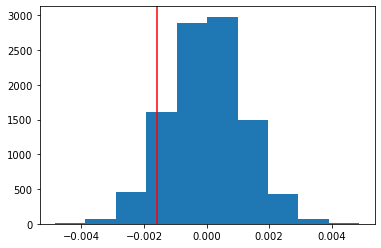

In [46]:
plt.hist(diffs);
plt.axvline(x=obs_diff, c='red');

Finally, we will calculate a proportion of our mean differences which are greater than our observed difference in data set and find our p_value.

In [47]:
obs_diff = conv_prob_treat - conv_prob_cont
obs_diff

-0.0015790565976871451

In [48]:
diffs_array = np.array(diffs)

In [49]:
pval = (diffs_array > obs_diff).mean()
pval

0.9087

**Double Check with NP method**

We will double check our value from the previous approach by using numpy random.binomial function.

In [50]:
new_converted_simulation = np.random.binomial(N_new, P_new, 10000)/N_new
old_converted_simulation = np.random.binomial(N_old, P_old, 10000)/N_old
p_diffs_2 = new_converted_simulation - old_converted_simulation

In [51]:
p_diffs_2

array([-0.00051831, -0.00192932, -0.00057361, ...,  0.00101672,
       -0.00011902, -0.00089711])

In [52]:
(p_diffs_2 > obs_diff).mean()

0.9033

As we can see, the p_value which we calculating using np method is identical to the one from the previous exercise.

**By calculating a proportion of our mean differences which are greater than our observed difference in data set, we calculated a p value which indicated the probability of observing our statistic if the null hypothesis is true. The P value of 0.91 is greater than our alpha level of 0.05 and as a result, we fail to reject a null hypothesis. This means, that our fictional company should not procced to implement a new page and should stay on the old one.**